# A General Case

Author(s): Kyle Godbey

Maintainer: Kyle Godbey

To take this particular problem to its natural conclusion, we will be now devising a way to automatically generate our Hamiltonian and ansatz circuits based on what basis dimension we want to calculate.

To do this in the most straightforward manner, I will first implement the Hamiltonian in second quantization before mapping it to a Pauli representation. To help out, I'll be importing some tools from qiskit as well as pennylane, proving that frameworks can indeed work together!

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
import time
from functools import partial
import warnings
warnings.filterwarnings('ignore')

We'll also need some helper functions to parse Pauli strings and construct our pennylane Hamiltonian, so I'll just dump them here.

In [2]:
def pauli_token_to_operator(token):
    qubit_terms = []

    for term in range(len(token)):
        # Special case of identity
        if token[term] == "I":
            pass
        else:
            #pauli, qubit_idx = term, term
            if token[term] == "X":
                qubit_terms.append(qml.PauliX(int(term)))
            elif token[term] == "Y":
                qubit_terms.append(qml.PauliY(int(term)))
            elif token[term] == "Z":
                qubit_terms.append(qml.PauliZ(int(term)))
            else:
                print("Invalid input.")
    if(qubit_terms==[]):
            qubit_terms.append(qml.Identity(0))
    full_term = qubit_terms[0]
    for term in qubit_terms[1:]:
        full_term = full_term @ term

    return full_term


def parse_hamiltonian_input(input_data):
    # Get the input
    coeffs = []
    pauli_terms = []
    chunks = input_data.split("\n")
    # Go through line by line and build up the Hamiltonian
    for line in chunks:
        #line = line.strip()
        tokens = line.split(" ")
        # Parse coefficients
        sign, value = tokens[0][0], tokens[1]

        coeff = float(value)
        if sign == "-":
            coeff *= -1
        coeffs.append(coeff)

        # Parse Pauli component
        pauli = tokens[3][::-1]
        
        pauli_terms.append(pauli_token_to_operator(pauli))

    return qml.Hamiltonian(coeffs, pauli_terms)


Something else that will be very important is a function to compute the matrix elements $\langle n' | (\hat{T} + \hat{V}) | n \rangle$ needed for our Hamiltonian.

In [3]:
def kron(i,j):
    if(i==j):
        return 1
    else:
        return 0

def matrix_element(i,j):
    
    ele = 0.0
    
    ele = ((2.0*i + 1.5)*kron(i,j) - np.sqrt(i*(i+0.5))*kron(i,j+1) \
    - np.sqrt((i+1)*(i+1.5))*kron(i,j-1)) * 3.5
    
    ele += -5.68658111 * kron(i,0) * kron(i,j)
    
    
    return ele

Lastly, we'll make a function that returns a pennylane compatible Hamiltonian given a requested basis dimension, N.

In [4]:
def deuteron_ham(N,mapper=JordanWignerMapper):
    # Start out by zeroing what will be our fermionic operator
    op = 0
    for i in range(N):
        for j in range(N):
            # Construct the terms of the Hamiltonian in terms of creation/annihilation operators 
            op += matrix_element(i,j) * \
            FermionicOp([([("+", i),("-", j)], 1.0)])

    hamstr = "+ "+str(mapper().map(second_q_op=op))

    hamiltonian = parse_hamiltonian_input(hamstr)

    return hamiltonian 


Let's take a look at our new Hamiltonian generator in the next code block. We'll start by setting the basis dimension to 3 so we can compare our two Hamiltonians: handcrafted and computer generated.

In [5]:
dim = 3

# Building our Hamiltonian for the N=3 case, as before

coeffs = [15.531709 ,-2.1433, -2.1433, 0.21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]

ham = qml.Hamiltonian(coeffs, obs)

# Let's print it out

print("Original Hamiltonian: \n",ham)

# Let's now use our new function!

H = deuteron_ham(dim)

print("Generated Hamiltonian: \n",H)

Original Hamiltonian: 
   (-9.625) [Z2]
+ (-6.125) [Z1]
+ (0.21829) [Z0]
+ (15.531709) [I0]
+ (-3.91) [X1 X2]
+ (-3.91) [Y1 Y2]
+ (-2.1433) [X0 X1]
+ (-2.1433) [Y0 Y1]
Generated Hamiltonian: 
   (-9.625) [Z2]
+ (-6.125) [Z1]
+ (0.21829055499999983) [Z0]
+ (15.531709445) [I0]
+ (-3.913118960624632) [Y1 Y2]
+ (-3.913118960624632) [X1 X2]
+ (-2.1433035249352805) [Y0 Y1]
+ (-2.1433035249352805) [X0 X1]


We still need to define our device and circuit, so we'll let them be general as well.

In [6]:
# Set the order you'd like to go to

dim = 5

dev = qml.device("default.qubit", wires=dim)

# Define a general ansatz for arbitrary numbers of dimensions

particles = 1

ref_state = qml.qchem.hf_state(particles, dim)

ansatz = partial(qml.ParticleConservingU2, init_state=ref_state)

layers = dim - 2


# Defining Hamiltonian

H = deuteron_ham(dim)

cost_fn = qml.ExpvalCost(ansatz, H, dev)


Amazing! That's an even better looking Hamiltonian!

Now we'll set up what we'll need for the VQE procedure, this time doing a loop over how many parameters we'll need.

In [7]:
# Our parameter array

init_params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=qml.ParticleConservingU2.shape(n_layers=layers, n_wires=dim))

# Convergence information and step size

max_iterations = 500
conv_tol = 1e-05
step_size = 0.1

Finally, the VQE block. We're still using the standard gradient descent optimizer since it worked so well before, but soon the time will come to shop around for better options. I have also added a quick and dirty variable step size just to speed things up slightly.

In [8]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

accel = 0
prev_conv = -1.0

start = time.time()

for n in range(max_iterations):
    fac = (1.0)
    opt = qml.GradientDescentOptimizer(stepsize=step_size)

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if(energy - prev_energy > 0.0 and step_size > 0.001):
        #print("Lowering!")
        accel = 0
        step_size = 0.5*step_size

    if(conv < prev_conv): accel += 1
    prev_conv = conv
    
    if(accel > 10 and step_size < 1.0):
        #print("Accelerating!")
        step_size = 1.1*step_size
    end = time.time()

    if n % 10 == 0:
        print(
            "It = {:},  Energy = {:.8f} MeV,  Conv = {"
            ":.8f} MeV, Time Elapsed = {:.3f} s".format(n, energy, conv,end-start)
        )
        start = time.time()


    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

It = 0,  Energy = 25.43598895 MeV,  Conv = 3.74111148 MeV, Time Elapsed = 0.811 s
It = 10,  Energy = -1.84990698 MeV,  Conv = 0.01447123 MeV, Time Elapsed = 8.448 s
It = 20,  Energy = -1.98298605 MeV,  Conv = 0.01369684 MeV, Time Elapsed = 8.302 s
It = 30,  Energy = -2.14395469 MeV,  Conv = 0.01093344 MeV, Time Elapsed = 8.459 s
It = 40,  Energy = -2.16828413 MeV,  Conv = 0.00097018 MeV, Time Elapsed = 8.162 s
It = 50,  Energy = -2.17146313 MeV,  Conv = 0.00033026 MeV, Time Elapsed = 8.317 s
It = 60,  Energy = -2.17539857 MeV,  Conv = 0.00686297 MeV, Time Elapsed = 8.247 s
It = 70,  Energy = -2.17669224 MeV,  Conv = 0.00011480 MeV, Time Elapsed = 8.408 s
It = 80,  Energy = -2.17847872 MeV,  Conv = 0.00023824 MeV, Time Elapsed = 8.537 s
It = 90,  Energy = -2.18142522 MeV,  Conv = 0.00030970 MeV, Time Elapsed = 8.183 s
It = 100,  Energy = -2.18264553 MeV,  Conv = 0.00060788 MeV, Time Elapsed = 8.361 s
It = 110,  Energy = -2.18294148 MeV,  Conv = 0.00002063 MeV, Time Elapsed = 8.373 s
It 

If you choose a bigger basis, you do a better job! This is to be expected, but notice that we've taken quite the performance hit by going to a more general representation. We'll explore how to do better at this in the optimization section, but for now let's check the convergence.

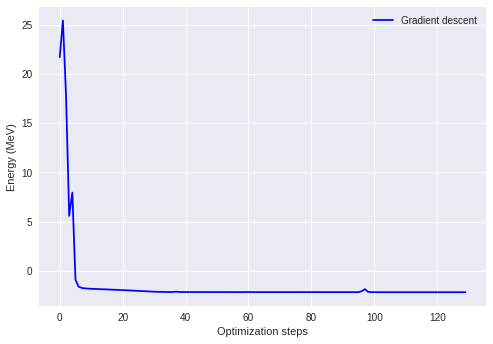

In [9]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Since we are now allowed to move in higher dimensions, making a general PES plotter gets a little tricky, but feel free to play around and see if you can think of clever ways to plot how your solution explores the space!

This pretty much concludes our exploration of quantum computing for the deuteron from the point of view of Hamiltonian and state preparation, but there's plenty of other things that can be tried to improve performance! One approach would involve optimizing the ansatz instead of using a generic form, which could be a fun challenge. Another approach is to speed up the VQE algorithm itself by being clever with how we iterate which is what we'll briefly explore next.